## 重新构建网络测试

## 1.检查数据集

(4, 5000) (5000,)
[6.2803371 6.2803371 6.2803371 6.2803371 6.2803371] [-19.75201981 -19.75201981 -19.75201981 -19.75201981 -19.75201981]


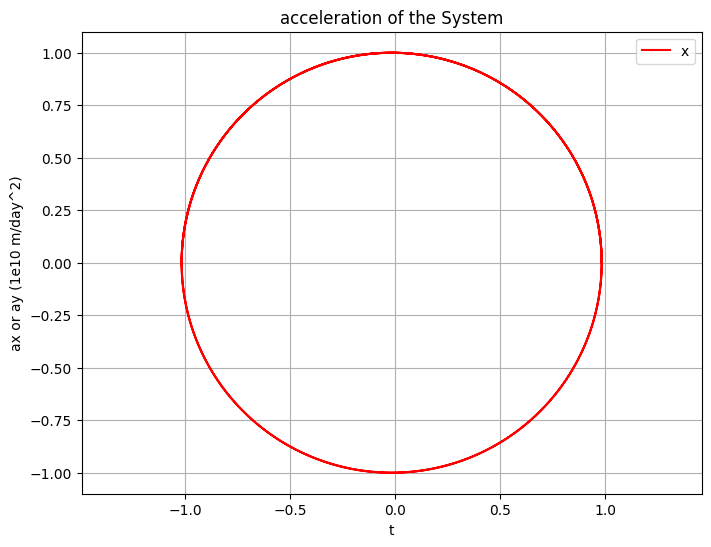

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 数据读取和预处理
# 加载数据
df = pd.read_csv('./earth_orbit_simulation.csv')
array = df.to_numpy()
array = array.T
t = array[0]
y = array[1:5]
angle_0 = array[-1]
energy_0 = array[-2]

t = t[:5000]
y = y[:,:5000]
angle_0 = angle_0[:5000]
energy_0 = energy_0[:5000] 

print(y.shape,t.shape)

print(angle_0[:5],energy_0[:5])
plt.figure(figsize=(8, 6))
plt.plot(y[0],y[1], color = 'red',label = 'x')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/day^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()



#  重建网络

In [10]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchdiffeq import odeint

class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.01)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)

class ODEFUN2(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        #self.stan = StanActivation(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim,32)
        self.fc2 = nn.Linear(32,2)

    # 初始化参数
        self._initialize_weights()

    def _initialize_weights(self):
        # 初始化策略：分层控制标准差
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 权重初始化：高斯分布
                init.normal_(m.weight, mean=0.0, std=0.01)
                
                # 偏置初始化：根据层类型区别处理
                if m in [self.net[0], self.net[2]]:  # 隐藏层
                    init.constant_(m.bias, 0.1)  # 小正值避免死神经元
                else:  # 输出层
                    init.normal_(m.bias, std=0.05)

    def forward(self, t, state):
 
        # 预测加速度
        Y = self.net(state)  
        #Y = self.stan(Y)
        Y = torch.tanh(Y)
        Y = self.fc1(Y)
        Y = torch.sin(Y)
        acceleration = self.fc2(Y)

        
        # 导数 [vx, vy, ax, ay]
        derivatives = torch.cat([state[0].unsqueeze(0),state[1].unsqueeze(0), acceleration[0].unsqueeze(0),acceleration[1].unsqueeze(0)])
        return derivatives



In [11]:
from torch.amp import GradScaler

scaler = GradScaler(
    init_scale=65536.0,        # 初始梯度缩放系数
    growth_factor=2.0,         # 梯度未溢出时增大系数
    backoff_factor=0.5,        # 梯度溢出时减小系数
    growth_interval=2000,      # 连续无溢出的迭代次数阈值
    enabled=True               # 显式启用（PyTorch >=2.1）
)


# 早停用函数
def errors(data):
    mean_value = np.mean(data)
    errors = data - mean_value
    absolute_errors = np.abs(errors)
    mae = np.mean(absolute_errors)
    return mae


def energy(Y, GM):
    x, y, vx, vy = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    K = (vx**2 + vy**2)/2 - GM/torch.sqrt(x**2 + y**2)
    return K

def angle(Y,GM):
    x, y, vx, vy = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    l = x*vy-y*vx
    return l

GM = 4 * np.pi**2

class CustomLoss():
    def __init__(self, alpha=0.1, beta=0.1, energy0=0, angle0=0):
        self.alpha = alpha
        self.beta = beta
        self.energy0 = energy0
        self.angle0 = angle0

    def __call__(self, y, y_target):
        trajectory_loss = torch.mean((y - y_target)**2)
        energy_loss = torch.mean((energy(y,GM)-self.energy0)**2)
        angle_loss = torch.mean((angle(y,GM)-self.angle0)**2)
        if self.alpha != 0 and self.beta != 0:
            return trajectory_loss  + self.alpha * energy_loss + self.beta * angle_loss
        if self.alpha == 0 and self.beta != 0:
            return trajectory_loss  + self.beta * angle_loss
        if self.beta == 0 and self.alpha != 0:
            return trajectory_loss  + self.alpha * energy_loss
        if self.beta == 0 and self.alpha == 0:
            return trajectory_loss
        
# 超参数设置
loss_value = []
mini_delta = 0.005
sum_ = np.array([0,0,0,0,0])

# 定义训练函数
def train(model,optimizer,criterion,epochs,coords, t_span):
    model.train()
    for epoch in range(epochs+1):

        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
            pred_trajectory = odeint(model, coords[0], t_span, method='dopri5', rtol=1e-4, atol=1e-5, )
        
            # 计算损失
            loss = criterion(pred_trajectory, coords)
        
        scaler.scale(loss).backward()   # 缩放损失并反向传播
        scaler.step(optimizer)          # 更新参数（自动unscale梯度）
        scaler.update()                 # 调整缩放系数
        optimizer.zero_grad()           # 清空梯度
        
        # 打印损失
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

        #设置早停
        loss_value.append(loss.item())
        if epoch > 5:
            for i in range(5):
                sum_[i] = loss_value[epoch]-loss_value[epoch-i-1]
        err = errors(sum_)

        if epoch == epochs:
            torch.save(model.state_dict(), 'ax_ay_model_params.pth')

        if loss.item() < 0.01 and err < 0.001 :
            torch.save(model.state_dict(), 'ax_ay_model_params.pth')
            break


In [ ]:
import torch.optim as optim
import torch

# 确认CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#传入数据

GM = 4 * np.pi**2
coords = torch.tensor(y.T, dtype=torch.float32).to(device)
t_tensor = torch.tensor(t,dtype=torch.float32).to(device)
energy_0 =  torch.tensor(energy_0,dtype=torch.float32).to(device)
angle_0 =  torch.tensor(angle_0,dtype=torch.float32).to(device)



Using device: cuda


C:\Users\19464\AppData\Local\Temp\ipykernel_35876\4187936274.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ax_test_model_params.pth'

In [ ]:
#设置训练：
model = ODEFUN2().to(device)
model.load_state_dict(torch.load('ax_test_model_params.pth'),weights_only=True)
optimizer = optim.Adamax(model.parameters(), lr=0.001)
epochs = 500
loss = CustomLoss(0,0,energy_0,angle_0)

train(model,optimizer,loss,epochs,coords,t_tensor)

Epoch 0, Loss: 17.082942962646484


In [ ]:
torch.save(model.state_dict(), 'ax_test_model_params.pth')

In [ ]:
train(model,optimizer,loss,epochs,coords,t_tensor)